# AtmoML Hyperparameter Tuning

In [1]:
import logging
import keras_tuner
import keras
import time
import pathlib

from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars


logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

2025-03-11 13:57:21.706511: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 13:57:21.758683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-11 13:57:21.758721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-11 13:57:21.760068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 13:57:21.768270: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tuner = keras_tuner.BayesianOptimization(
    AtmoModel.get_hypermodel(
        input_cnn_kernel_size=[1, 2, 5],
        lstm_kernel_size=[5],
    ),
    objective="val_loss",
    max_trials=10,
    project_name=f"logs/htune_project_{timestamp}",
)
tuner.search_space_summary()

Search space summary
Default search space size: 2
input_cnn_kernel_size (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 5], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}


In [ ]:
log_dir = f"logs/htune_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 3 Complete [00h 00m 15s]
val_loss: 0.22705864906311035

Best val_loss So Far: 0.20077180862426758
Total elapsed time: 00h 01m 31s


{'input_cnn_kernel_size': 2, 'lstm_kernel_size': 5}

In [ ]:
# Train the best option further and save.
model = AtmoModel(model=best_model)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=200, callbacks=[tb_callback], validation_freq=10)
model.save_model(log_dir + "/model")

Epoch 1/2
1/1 [==============================] - 10s 10s/step - loss: 0.1983 - mean_absolute_error: 0.3085 - root_mean_squared_error: 0.4454 - mean_absolute_percentage_error: 735.0610 - nrmse: 0.4454 - ssim_metric: 0.0914 - psnr_metric: 3.8154 - mse_RH2: 0.1606 - mse_T2: 0.3921 - mse_WSPD_WDIR10: 0.0238 - mse_WSPD_WDIR10_COS: 0.1954 - mse_WSPD_WDIR10_SIN: 0.2199
Epoch 2/2
1/1 [==============================] - 1s 692ms/step - loss: 0.1250 - mean_absolute_error: 0.2543 - root_mean_squared_error: 0.3536 - mean_absolute_percentage_error: 4494.0410 - nrmse: 0.3536 - ssim_metric: 0.2225 - psnr_metric: 9.2572 - mse_RH2: 0.1155 - mse_T2: 0.1137 - mse_WSPD_WDIR10: 0.0015 - mse_WSPD_WDIR10_COS: 0.1746 - mse_WSPD_WDIR10_SIN: 0.2198
INFO:tensorflow:Assets written to: logs/htune_20250311-135724/model/assets


INFO:tensorflow:Assets written to: logs/htune_20250311-135724/model/assets


/home/elhajjas/climateiq-cnn-8/usl_models/usl_models/atmo_ml/visualizer.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, T, figsize=(2 * (T + 0.2), 2), sharey=True)


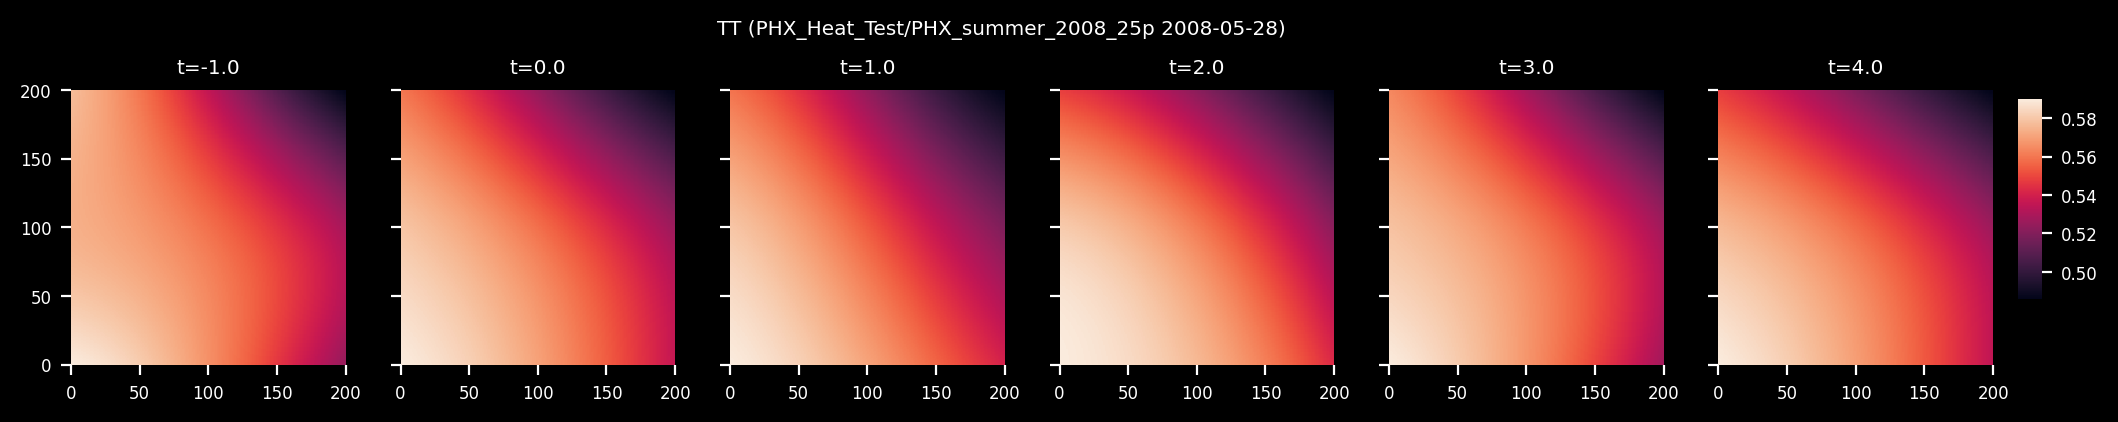

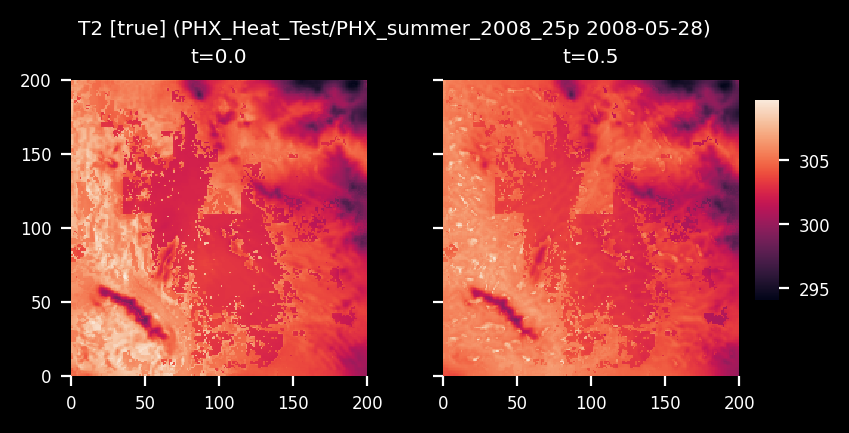

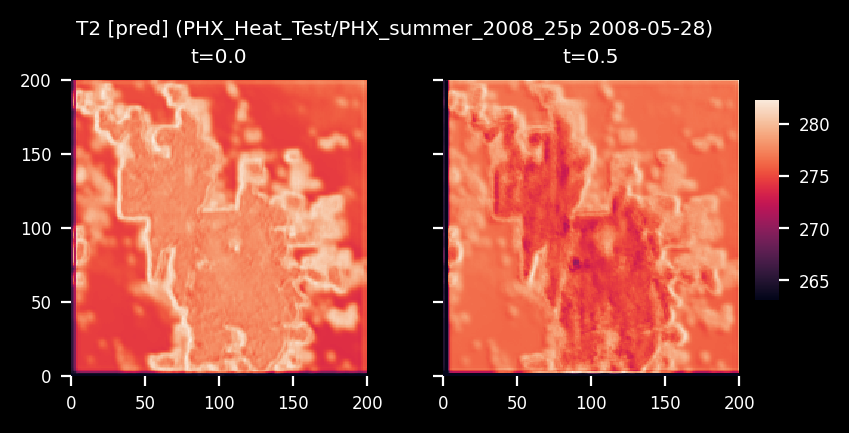

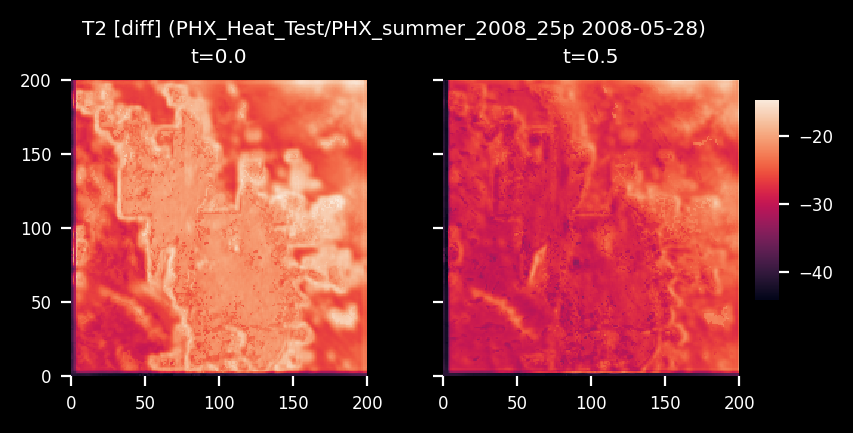

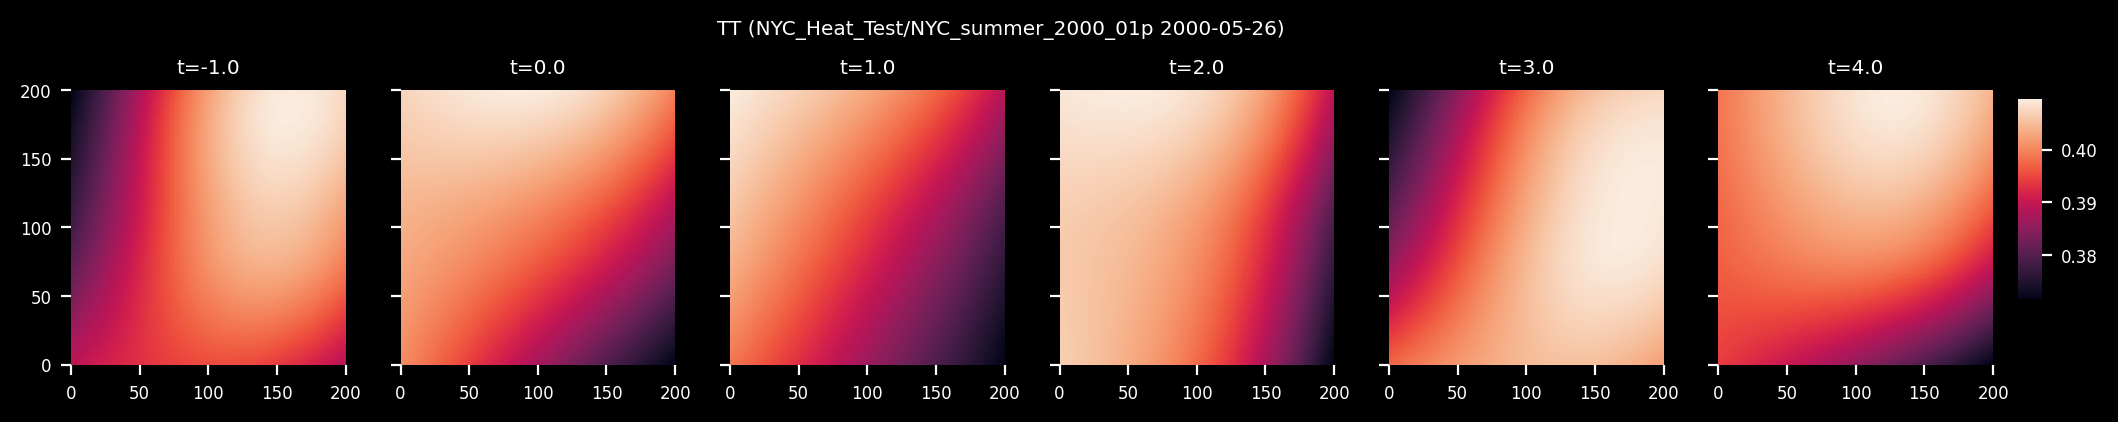

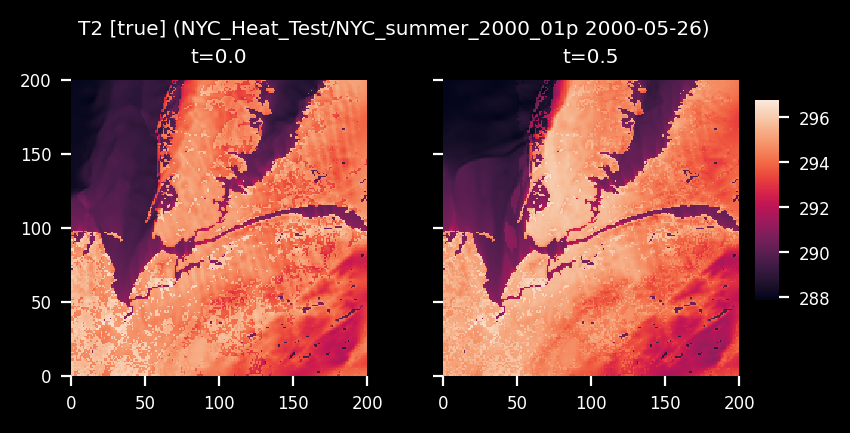

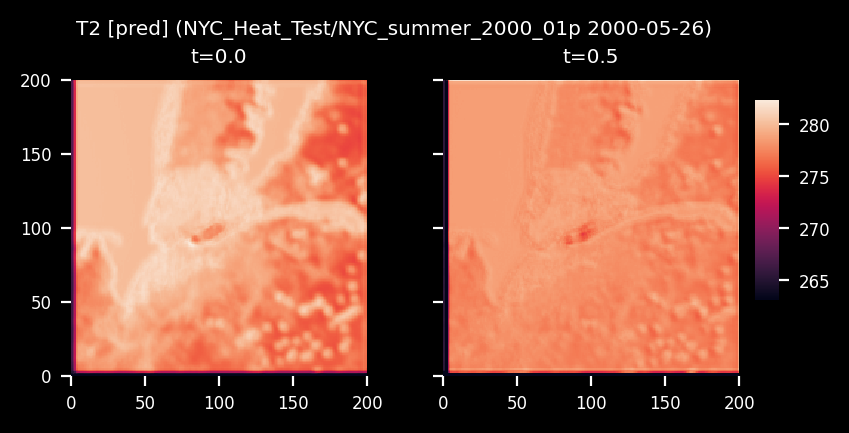

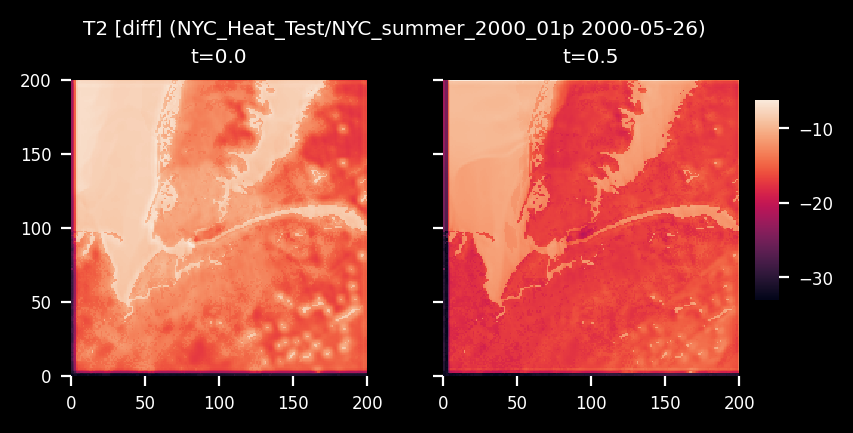

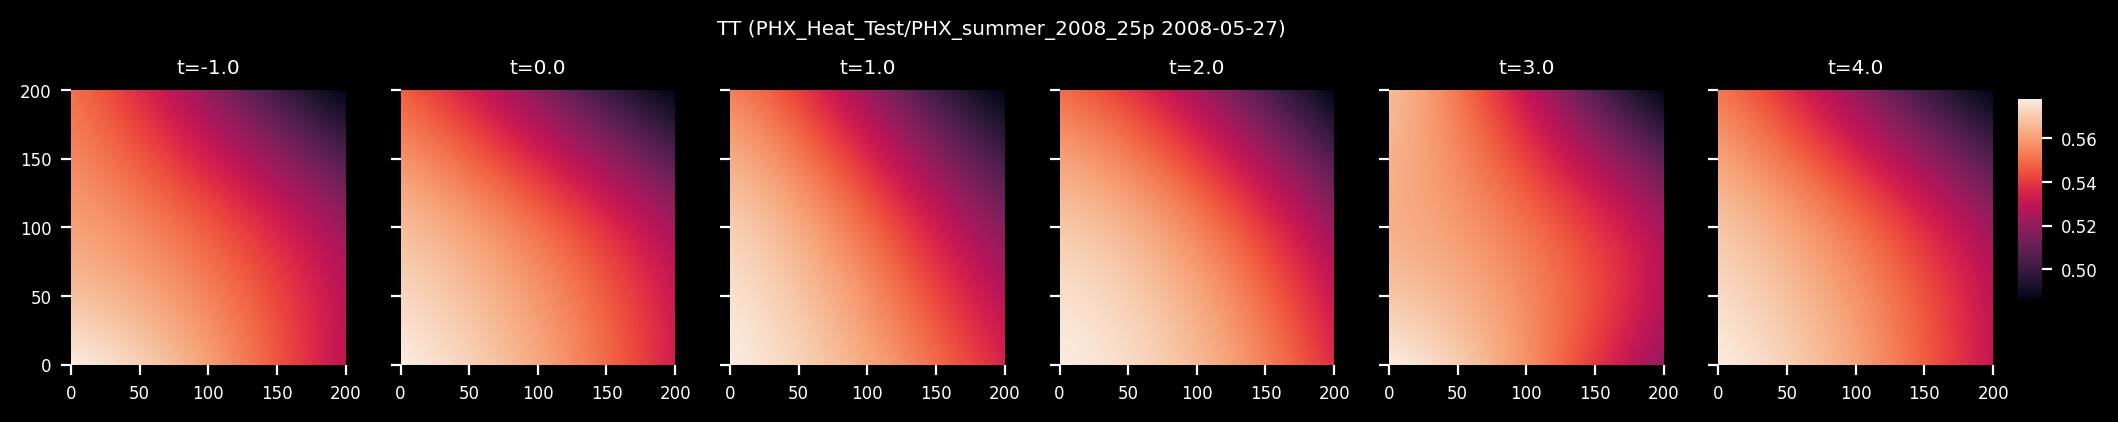

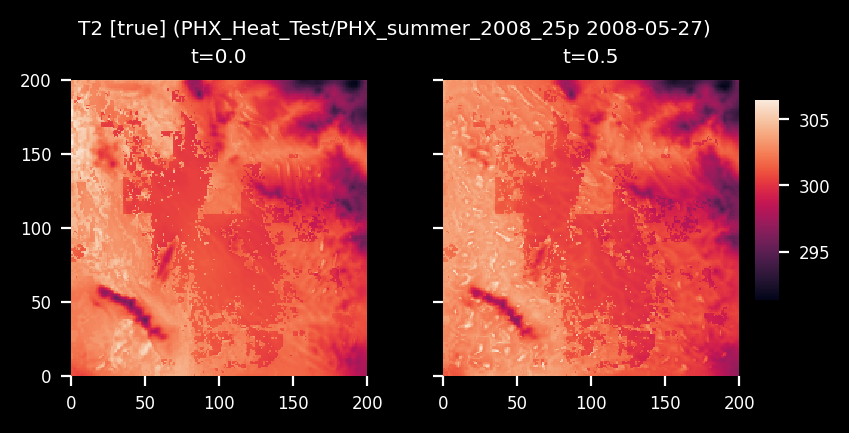

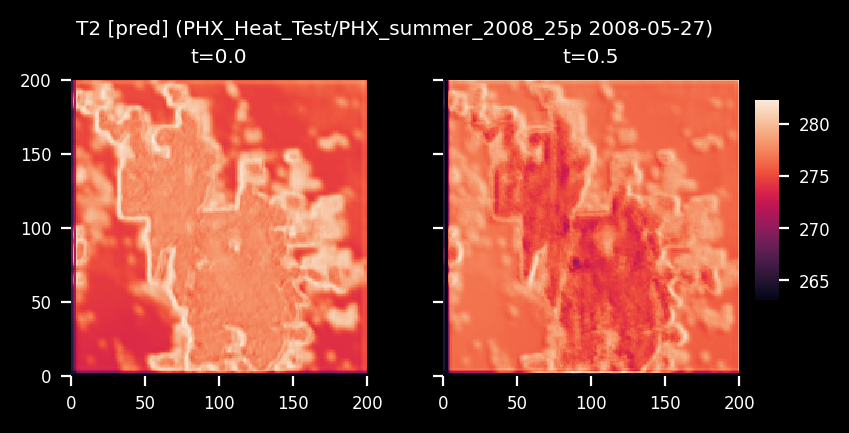

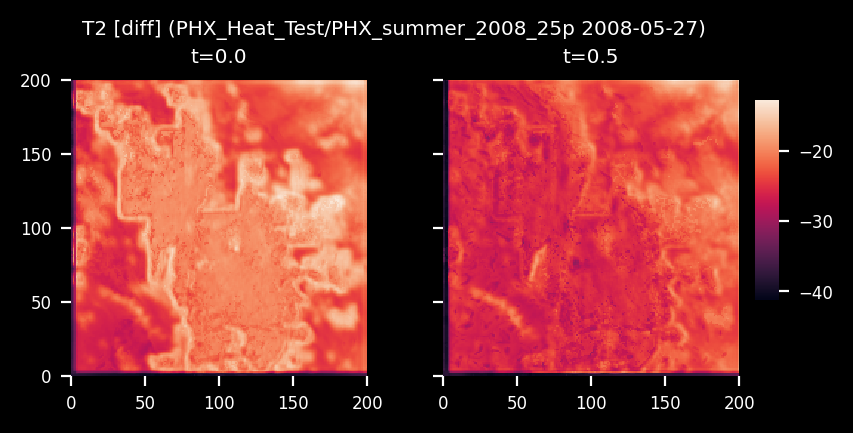

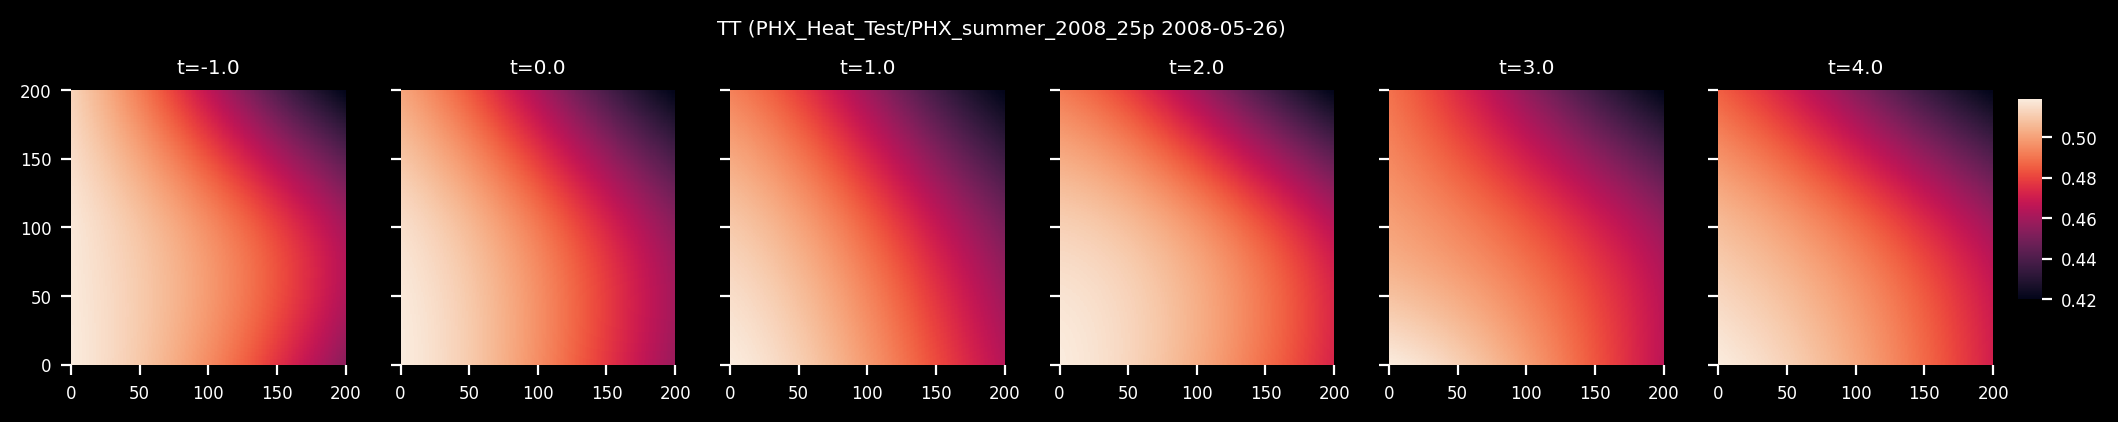

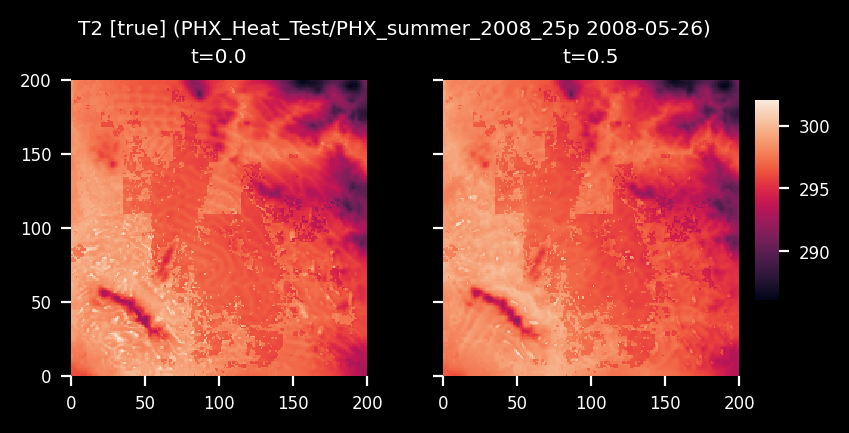

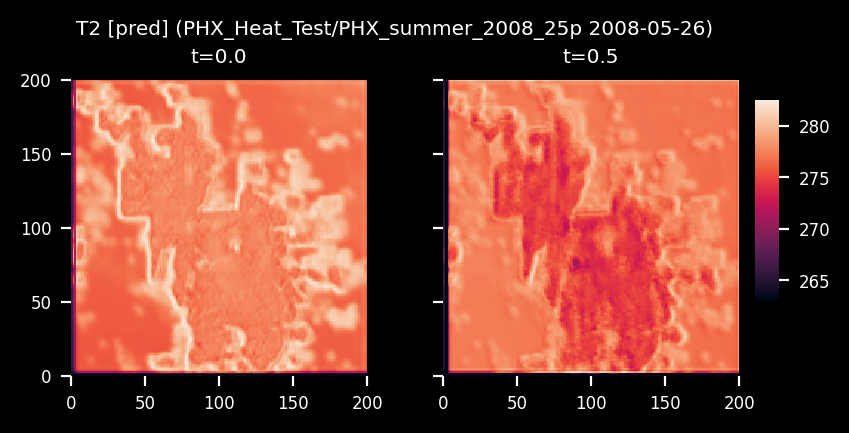

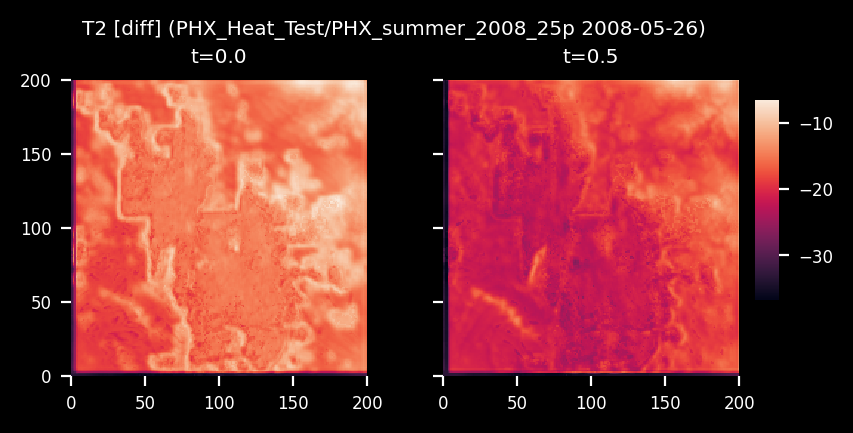

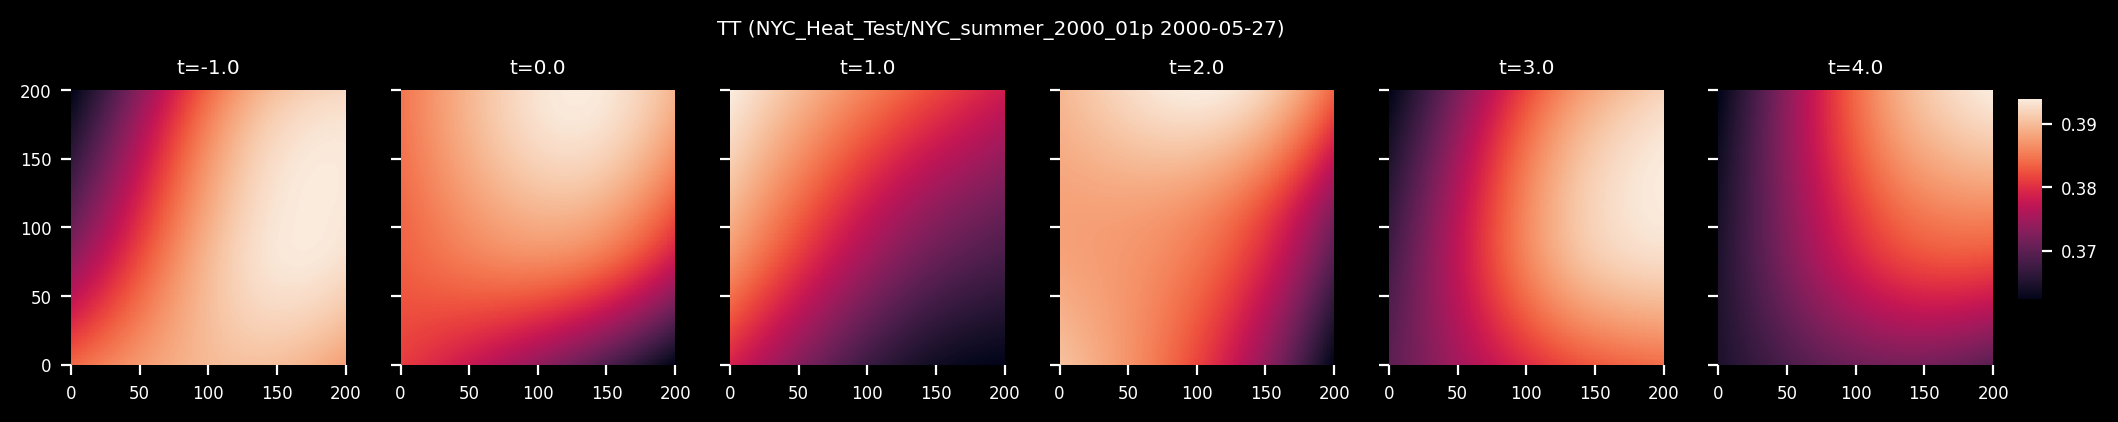

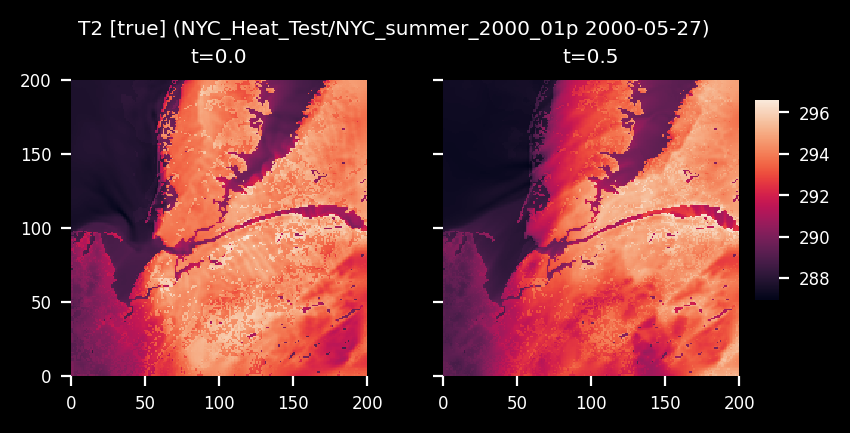

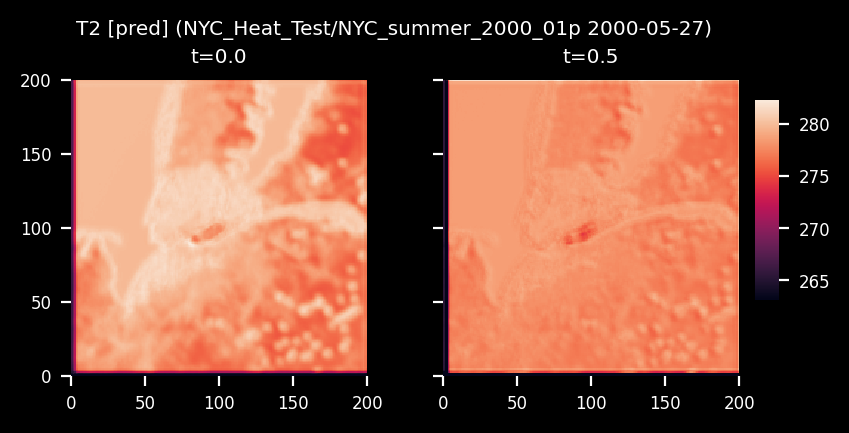

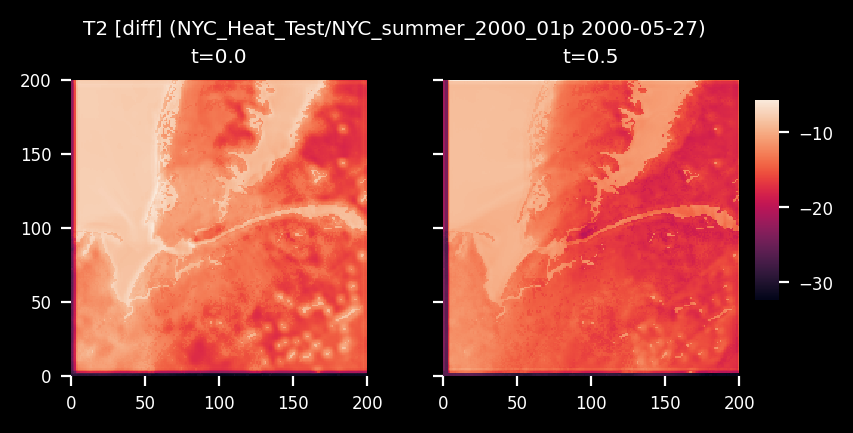

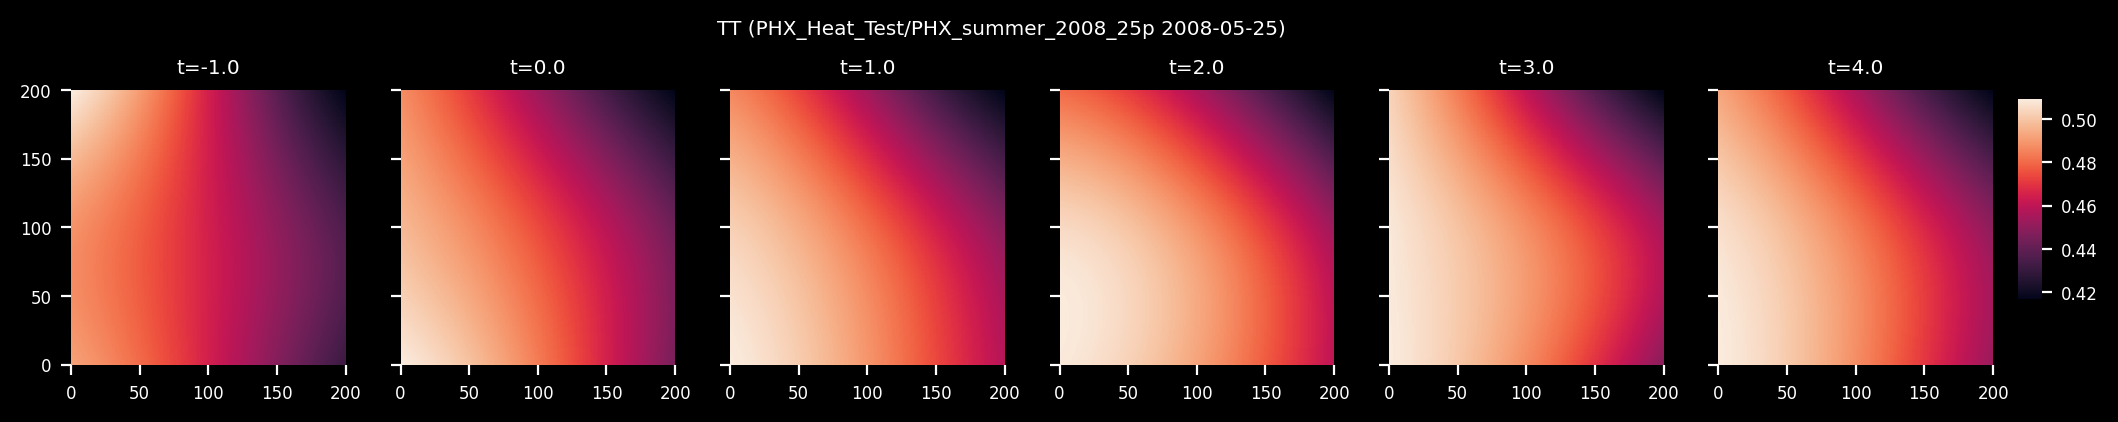

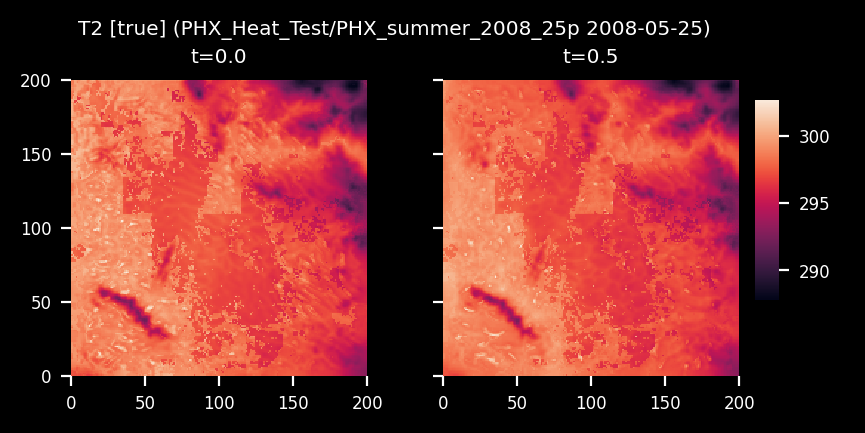

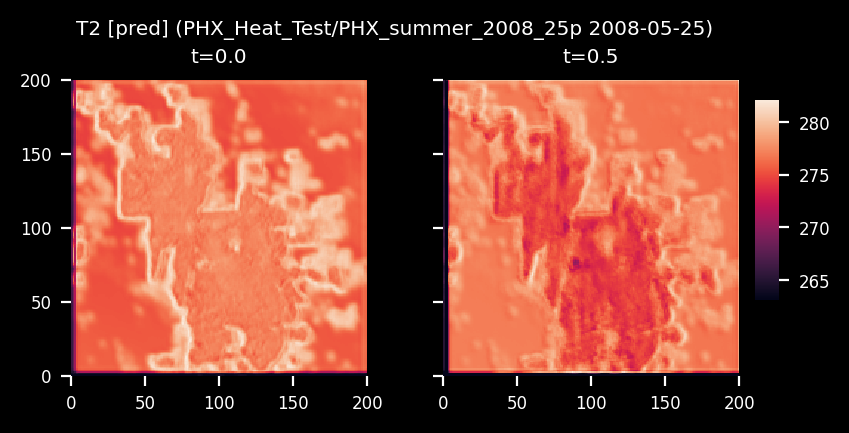

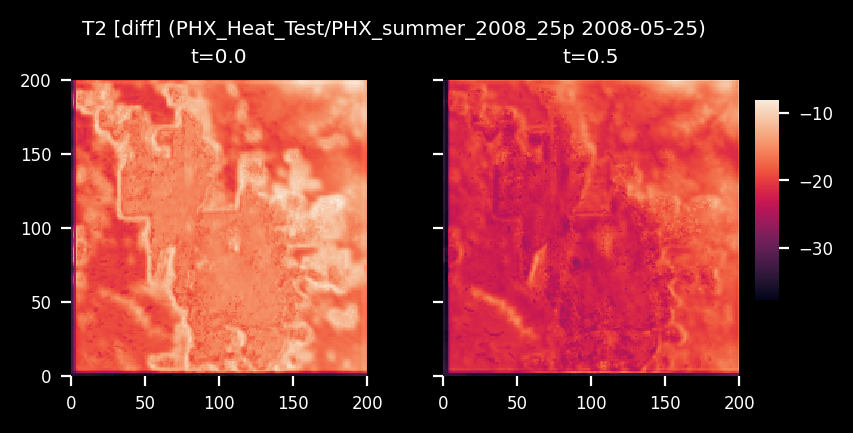

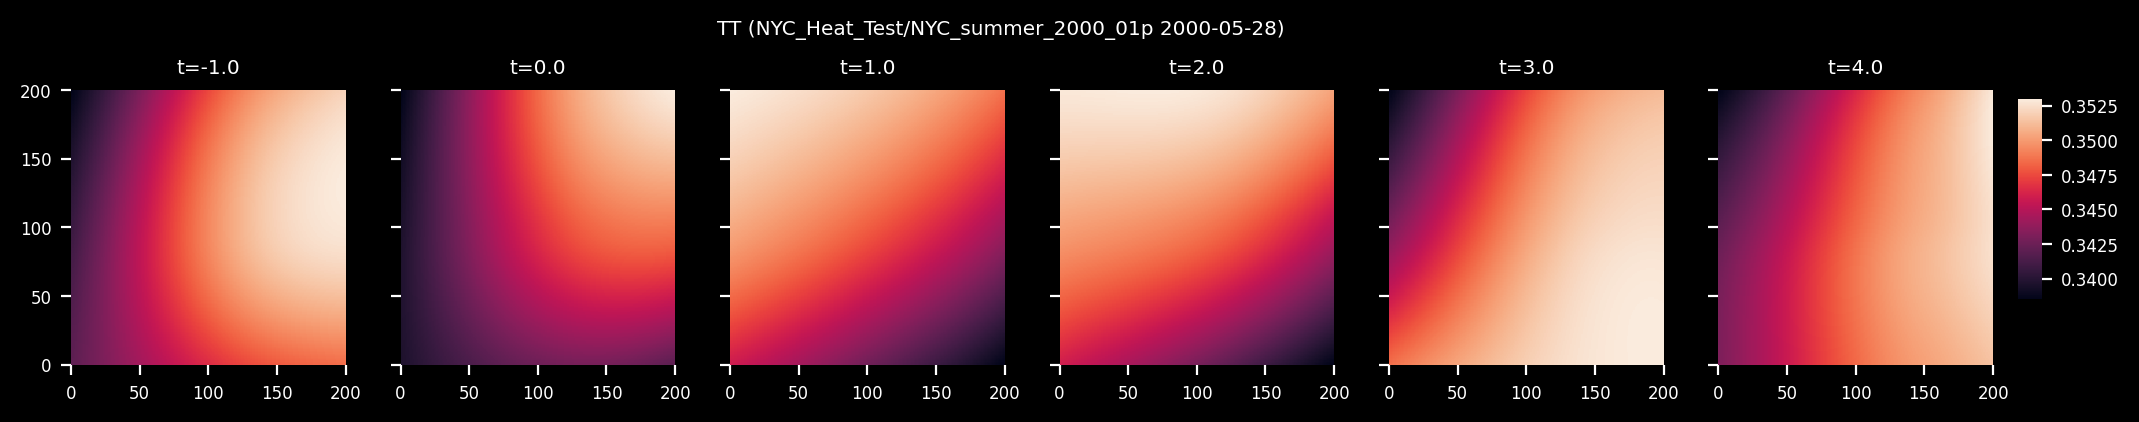

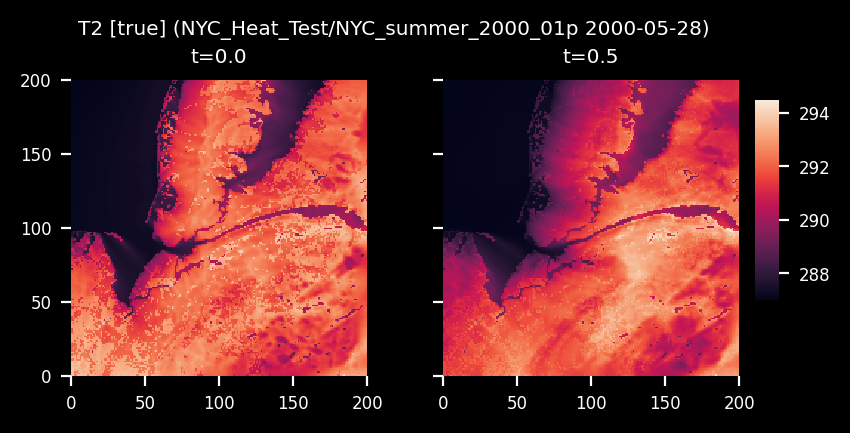

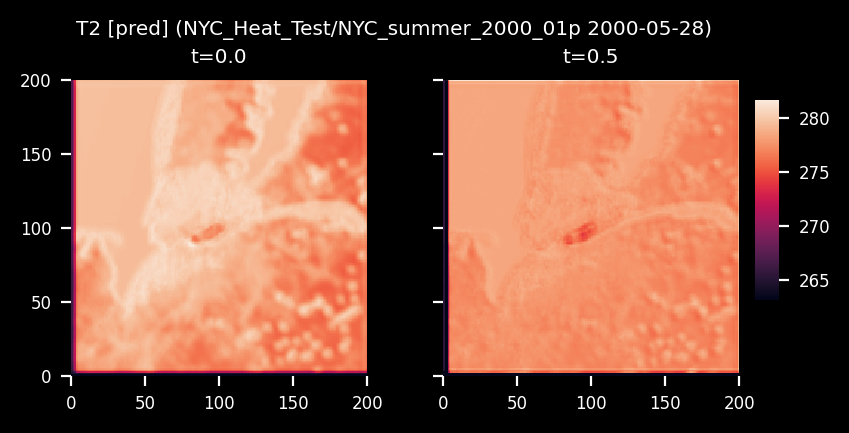

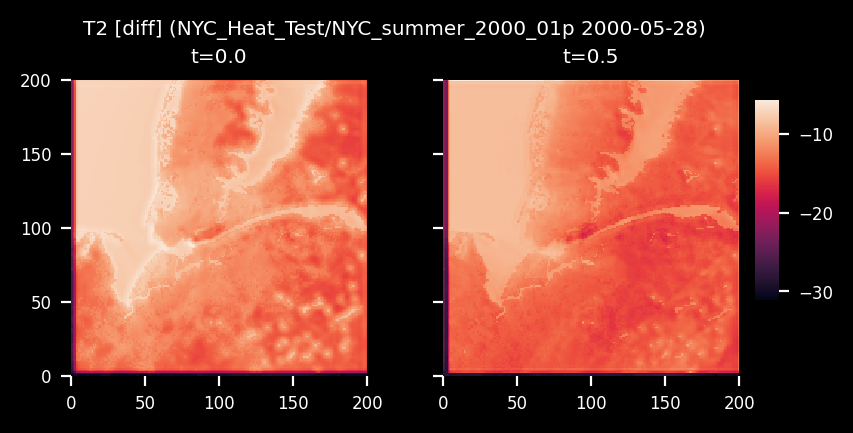

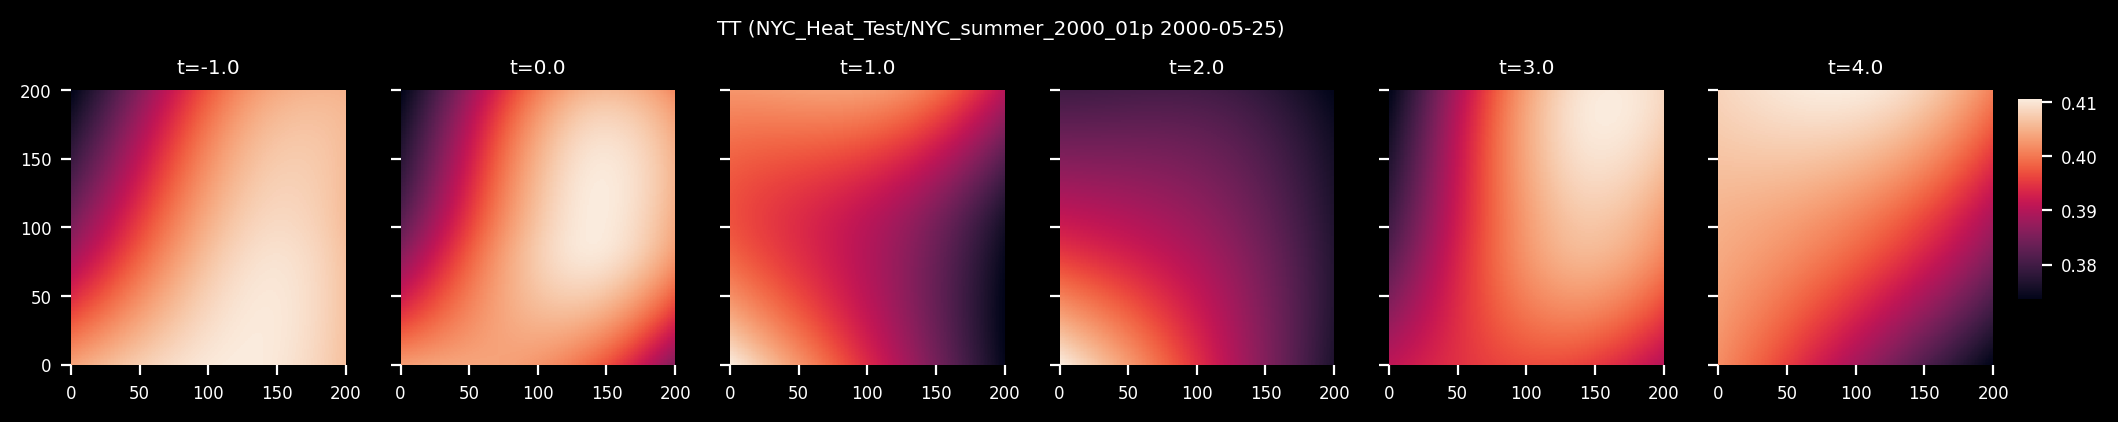

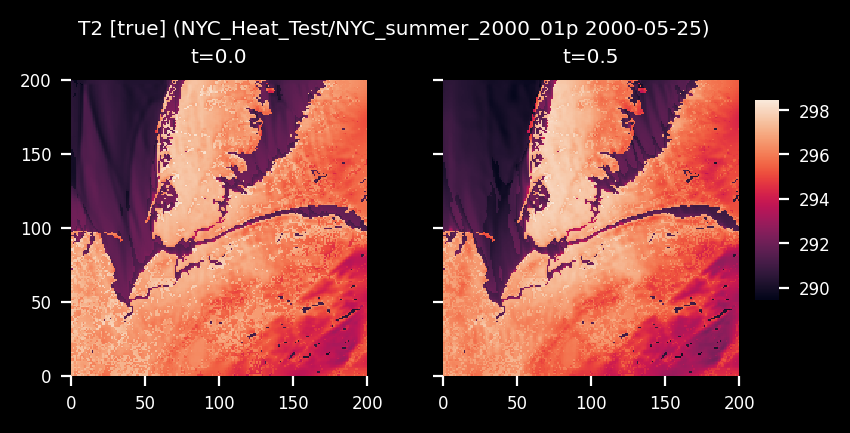

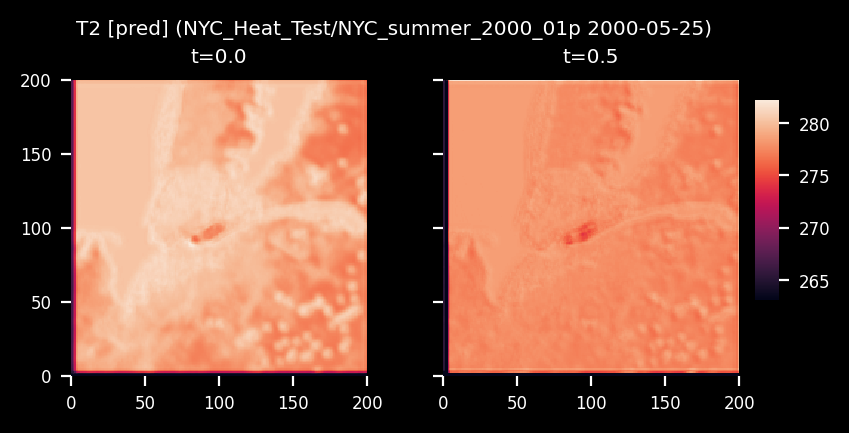

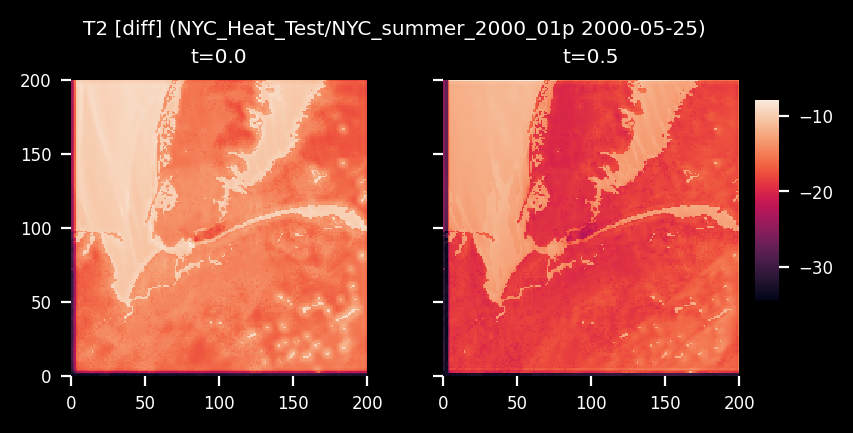

In [5]:
# Plot results
model = AtmoModel.from_checkpoint(log_dir + "/model")
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.TT,
    sto_var=vars.SpatiotemporalOutput.T2,
    max_examples=None,
    gt_vmin=10.0,   # desired minimum for ground truth plots
    gt_vmax=50.0,   # desired maximum for ground truth plots
    pred_vmin=5.0,  # desired minimum for prediction plots
    pred_vmax=45.0, # desired maximum for prediction plots
    unscale=True,   # revert normalization to show true values
):
    fig.show()
